In [556]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import getpass
username = getpass.getuser()

import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/data_preprocessing_code'.format(username))
sys.path.append('/Users/{:}/GitHub/mouse_bandit'.format(username))
import support_functions as sf

%matplotlib inline

In [557]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
#data = data[data['Mouse ID']=='Baby']
data = data[data['Condition']=='80-20']
data.head()

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
106400,0,Baby,01112018_Baby,11.0,11.0,5.0,2.0,-2.0,0.0,1.0,...,0.566,1.544,0.560,0.0,1.0,1.0,1.0,80-20,1.0,13.0
106401,1,Baby,01112018_Baby,12.0,12.0,6.0,1.0,1.0,0.0,1.0,...,0.560,2.506,0.497,0.0,0.0,1.0,1.0,80-20,1.0,13.0
106402,2,Baby,01112018_Baby,13.0,0.0,7.0,2.0,2.0,0.0,0.0,...,0.497,2.526,0.562,0.0,0.0,0.0,0.0,80-20,2.0,53.0
106403,3,Baby,01112018_Baby,14.0,1.0,0.0,3.0,-1.0,1.0,0.0,...,0.562,1.780,0.587,0.0,0.0,0.0,0.0,80-20,2.0,53.0
106404,4,Baby,01112018_Baby,15.0,2.0,0.0,4.0,-2.0,0.0,1.0,...,0.587,4.313,0.382,1.0,1.0,1.0,1.0,80-20,2.0,53.0


### make some new dataframes
    X has predictor variables (choice and reward history for past n trials) relevant variables for logit model
    Y has dependent variable (choice on current trial)

In [558]:
#include past 10 choice and reward values (this is most convenient given the current data structure)
port_features = []
reward_features = []
for col in data.columns:
    if '_Port' in col:
        port_features.append(col)
    if '_Reward' in col:
        reward_features.append(col)
        
choice_history = data[port_features]
reward_history = data[reward_features]

switch_cols = ['9_Switch','8_Switch','7_Switch','6_Switch','5_Switch','4_Switch','3_Switch','2_Switch','1_Switch']
switch_history = pd.DataFrame(np.abs(np.diff((choice_history))))
switch_history.columns=switch_cols
switch_history.index=reward_history.index

X_choice = pd.concat([choice_history.drop('10_Port', axis=1), reward_history.drop('10_Reward', axis=1)], axis=1)

X_switch = pd.concat([switch_history, reward_history.drop('10_Reward', axis=1)], axis=1)

X_choice_switch = pd.concat([switch_history, choice_history.drop('10_Port', axis=1), reward_history.drop('10_Reward', axis=1)], axis=1)

# value = L when choice = 0 and reward = 1 or when choice = 1 and reward = 0 
# value = R when choice = 1 and reward = 1 or when choice = 0 and reward = 0
X_value_history = (choice_history.values==reward_history.values).astype('int') # gives action value with R=1, L=0

Y_switch = data['Switch']

Y_choice = data['Decision']


### Logistic regression
Compare training on port choice (lr_port) vs training on switch (lr_switch)

### lr1 - train on port choice to predict port choice
#### Evaluate performance on predicting choice and predicting switches

In [559]:
X_train, X_test, y_train, y_test_choice = train_test_split(X_choice, Y_choice, test_size=0.3, random_state=1)

lr1_choice = LogisticRegression()
lr1_choice.fit(X_train, y_train)

lr1_choice_proba = lr1_choice.predict_proba(X_test)
lr1_choice_predict = lr1_choice.predict(X_test)

score_lr1_choice = lr1_choice.score(X_test, y_test_choice)
metrics_lr1_choice = sklearn.metrics.precision_recall_fscore_support(y_test_choice, lr1_choice_predict)

prev_choice = X_test['1_Port']
true_switch = np.abs(y_test_choice-prev_choice)
lr1_switch_predict = np.abs(lr1_choice_predict-prev_choice)
metrics_lr1_switch = sklearn.metrics.precision_recall_fscore_support(true_switch, lr1_switch_predict)

#acc_pos,acc_neg,F1=sf.score_both_and_confuse(lr1_switch_predict,Y_test_switch,confusion=False,disp=True)

/Users/celiaberon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### lr2 - train on switches to predict switches

In [560]:
# redefine training and testing sets to use switch history and current switch decision
X_train, X_test, y_train, y_test = train_test_split(X_switch, Y_switch, test_size=0.3, random_state=1)

# train and test LR
lr2_switch = LogisticRegression()
lr2_switch.fit(X_train, y_train)

lr2_switch_proba = lr2_switch.predict_proba(X_test)
lr2_switch_predict = lr2_switch.predict(X_test)

score_lr2_switch = lr2_switch.score(X_test, y_test)
metrics_lr2_switch = sklearn.metrics.precision_recall_fscore_support(y_test, lr2_switch_predict)


In [561]:
test = lr2_switch_proba[:,1]>0.2
sklearn.metrics.precision_recall_fscore_support(y_test, test)

(array([ 0.9673328 ,  0.33304598]),
 array([ 0.92530733,  0.54413146]),
 array([ 0.94585348,  0.41319073]),
 array([31074,  2130]))

(array([  2.53530000e+04,   2.90700000e+03,   1.88100000e+03,
          1.56300000e+03,   7.00000000e+02,   4.15000000e+02,
          2.11000000e+02,   1.11000000e+02,   5.40000000e+01,
          9.00000000e+00]),
 array([ 0.00545636,  0.07950938,  0.1535624 ,  0.22761542,  0.30166844,
         0.37572147,  0.44977449,  0.52382751,  0.59788053,  0.67193355,
         0.74598658]),
 <a list of 10 Patch objects>)

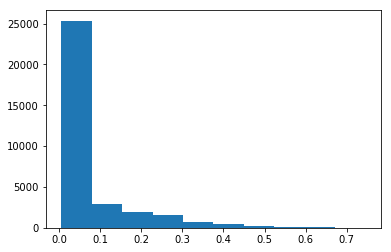

In [562]:
plt.hist(lr2_switch_proba[:,1])

### lr2.1 - change decision boundary

In [563]:
metrics_db = []
decision_boundaries = np.arange(0.05,0.6,0.05)
for boundary in decision_boundaries:
    temp_predict = lr2_switch_proba[:,1]>boundary
    metrics_temp = sklearn.metrics.precision_recall_fscore_support(y_test, temp_predict)
    metrics_db.append(metrics_temp)

In [564]:
decision_boundaries

array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55])

In [565]:
metrics_db

[(array([ 0.98768797,  0.16608595]),
  array([ 0.69962026,  0.87276995]),
  array([ 0.81906377,  0.27906628]),
  array([31074,  2130])),
 (array([ 0.98108454,  0.24606776]),
  array([ 0.83957649,  0.76384977]),
  array([ 0.90483127,  0.37222604]),
  array([31074,  2130])),
 (array([ 0.97458708,  0.28316633]),
  array([ 0.88488769,  0.66338028]),
  array([ 0.92757388,  0.39691011]),
  array([31074,  2130])),
 (array([ 0.9673328 ,  0.33304598]),
  array([ 0.92530733,  0.54413146]),
  array([ 0.94585348,  0.41319073]),
  array([31074,  2130])),
 (array([ 0.96048266,  0.37225386]),
  array([ 0.95034434,  0.42957746]),
  array([ 0.95538661,  0.39886661]),
  array([31074,  2130])),
 (array([ 0.95256131,  0.4122288 ]),
  array([ 0.97122997,  0.2943662 ]),
  array([ 0.96180506,  0.34346754]),
  array([31074,  2130])),
 (array([ 0.94664762,  0.4107677 ]),
  array([ 0.98098088,  0.19342723]),
  array([ 0.96350849,  0.2630067 ]),
  array([31074,  2130])),
 (array([ 0.94205389,  0.38906752]),
  ar

In [566]:
y_predict = lr2_switch_proba[:,1] > 0.2

score_switch_2 = 1-(np.sum(np.abs(y_predict - y_test)) / (len(y_test)))
#switch_predict_2 = np.abs([y_predict[n,1] - X_test[n,8] for n in range(len(y_predict))])

metrics_switch_3 = sklearn.metrics.precision_recall_fscore_support(y_test, y_predict)


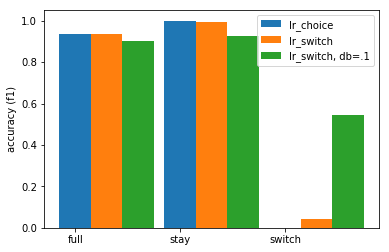

In [567]:
height_a = [score_lr1_choice, metrics_lr1_switch[1][0], metrics_lr1_switch[1][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[1][0], metrics_lr2_switch[1][1]]
height_c = [score_switch_2, metrics_switch_3[1][0], metrics_switch_3[1][1]]

barWidth = 0.3
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr_choice')
plt.bar(r2, height_b, width=barWidth, label='lr_switch')
plt.bar(r3, height_c, width=barWidth, label='lr_switch, db=.1')
plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy (f1)')
plt.legend()

### lr3 - use action value to predict choice

In [568]:
# redefine training set to use value history
X_train, X_test, y_train, y_test_choice = train_test_split(X_value_history, Y_choice, test_size=0.3, random_state=1)

# train and test LR
lr3_value = LogisticRegression()
lr3_value.fit(X_train, y_train)

lr3_value_proba = lr3_value.predict_proba(X_test)
lr3_value_predict = lr3_value.predict(X_test)

score_lr3_value_choice = lr3_value.score(X_test, y_test_choice)
metrics_lr3_value = sklearn.metrics.precision_recall_fscore_support(y_test_choice, lr3_value_predict)

lr3_switch_predict = np.abs(lr3_value_predict-prev_choice)
#lr3_switch_predict = np.abs([lr3_value_predict[n] - X_test[n,8] for n in range(len(lr3_value_predict))])
metrics_lr3_switch = sklearn.metrics.precision_recall_fscore_support(y_test_choice, lr3_switch_predict)

#score_switch_2 = 1-(np.sum([np.abs(lr3_value_predict[i] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))


### what about a logistic regression with more inputs?

In [569]:
#train on proportion of data up to the 'cutoff.' hold out the rest as test data.
X_train, X_test, y_train, y_test_choice = train_test_split(X_choice_switch, Y_choice, test_size=0.3, random_state=1)

# train and test LR
lr4_multi = LogisticRegression()
lr4_multi.fit(X_train, y_train)

lr4_multi_proba = lr4_multi.predict_proba(X_test)
lr4_multi_predict = lr4_multi.predict(X_test)

score_lr4_multi_choice = lr4_multi.score(X_test, y_test_choice)
metrics_lr4_choice = sklearn.metrics.precision_recall_fscore_support(y_test_choice, lr4_multi_predict)

lr4_switch_predict = np.abs(lr4_multi_predict-prev_choice)
#lr4_switch_predict = np.abs([lr4_multi_predict[n] - X_test[n,8] for n in range(len(lr4_multi_predict))])
metrics_lr4_switch = sklearn.metrics.precision_recall_fscore_support(true_switch, lr4_switch_predict)

#score_switch_2 = 1-(np.sum([np.abs(lr4_multi_predict[i] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))

'''
Now train to predict switches
'''

X_train, X_test, y_train, y_test = train_test_split(X_choice_switch, Y_switch, test_size=0.3, random_state=1)

lr5_multi = LogisticRegression()
lr5_multi.fit(X_train, y_train)

lr5_multi_proba = lr5_multi.predict_proba(X_test)
lr5_multi_predict = lr5_multi.predict(X_test)

score_lr5_multi_switch = lr5_multi.score(X_test, y_test)
metrics_lr5_switch = sklearn.metrics.precision_recall_fscore_support(y_test, lr5_multi_predict)


/Users/celiaberon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## F1 score

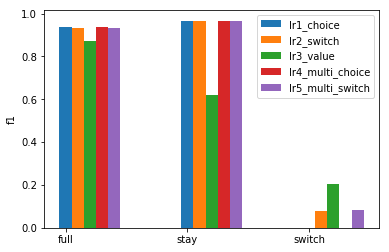

In [570]:
height_a = [score_lr1_choice, metrics_lr1_switch[2][0], metrics_lr1_switch[2][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[2][0], metrics_lr2_switch[2][1]]
height_c = [score_lr3_value_choice, metrics_lr3_switch[2][0], metrics_lr3_switch[2][1]]
height_d = [score_lr4_multi_choice, metrics_lr4_switch[2][0], metrics_lr4_switch[2][1]]
height_e = [score_lr5_multi_switch, metrics_lr5_switch[2][0], metrics_lr5_switch[2][1]]

barWidth = 0.1
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr1_choice')
plt.bar(r2, height_b, width=barWidth, label='lr2_switch')
plt.bar(r3, height_c, width=barWidth, label='lr3_value')
plt.bar(r4, height_d, width=barWidth, label='lr4_multi_choice')
plt.bar(r5, height_e, width=barWidth, label='lr5_multi_switch')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('f1')
plt.legend()

## Accuracy/recall
### predicted switches/stays out of total true switches/stays

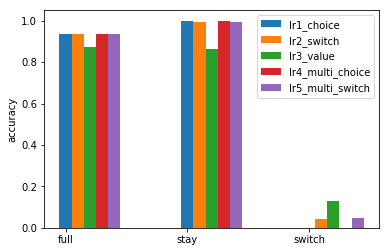

In [571]:
height_a = [score_lr1_choice, metrics_lr1_switch[1][0], metrics_lr1_switch[1][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[1][0], metrics_lr2_switch[1][1]]
height_c = [score_lr3_value_choice, metrics_lr3_switch[1][0], metrics_lr3_switch[1][1]]
height_d = [score_lr4_multi_choice, metrics_lr4_switch[1][0], metrics_lr4_switch[1][1]]
height_e = [score_lr5_multi_switch, metrics_lr5_switch[1][0], metrics_lr5_switch[1][1]]

barWidth = 0.1
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr1_choice')
plt.bar(r2, height_b, width=barWidth, label='lr2_switch')
plt.bar(r3, height_c, width=barWidth, label='lr3_value')
plt.bar(r4, height_d, width=barWidth, label='lr4_multi_choice')
plt.bar(r5, height_e, width=barWidth, label='lr5_multi_switch')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy')
plt.legend()

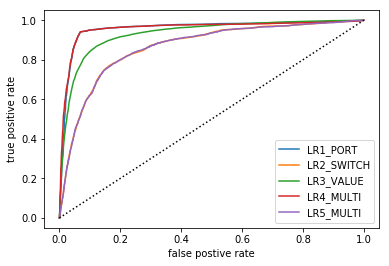

In [572]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test_choice, lr1_choice_proba[:,1])
plt.plot(fpr, tpr, label="LR1_PORT")

fpr, tpr, _ = roc_curve(y_test, lr2_switch_proba[:,1])
plt.plot(fpr, tpr, label="LR2_SWITCH")

fpr, tpr, _ = roc_curve(y_test_choice, lr3_value_proba[:,1])
plt.plot(fpr, tpr, label="LR3_VALUE")

fpr, tpr, _ = roc_curve(y_test_choice, lr4_multi_proba[:,1])
plt.plot(fpr, tpr, label="LR4_MULTI")

fpr, tpr, _ = roc_curve(y_test, lr5_multi_proba[:,1])
plt.plot(fpr, tpr, label="LR5_MULTI")

plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')

plt.legend(loc='lower right')

In [573]:
lr1_choice.coef_

array([[  1.71109698e-01,   2.79426083e-01,   1.48025543e-01,
          1.92838278e-01,   2.07636109e-01,   3.69509408e-01,
          3.48499483e-01,   4.80193586e-01,   4.03263523e+00,
          2.30711289e-02,   6.13550700e-02,  -4.90156716e-02,
          1.03935919e-01,  -4.03401290e-02,  -2.66459878e-03,
          6.01904951e-02,   1.75792815e-02,  -2.40016025e-02]])

In [574]:
#plt.plot(np.arange(lr1_choice.coef_.shape[1]-10),lr1_choice.coef_[0][0:10]) # to only include one type of parameters